**step1:** 导入包库以及定义超参数

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 参数定义
iteration_times = 500  # 迭代次数
K = 10  # 潜在特征数
lamb = 0.5  # 惩罚系数
fig_config = {  # 绘图参数
    'title': 'validation loss',
    'xlabel': 'iteration times',
    'ylabel': 'loss value',
    'color_shape': ['c', 'orange', 'pink', 'g', 'k', 'm', 'r', 'y'],
    'label': ['validation loss'],
    'figsize': (6, 4)
}

**step2:** 根据文件目录导入数据，并合并好训练集以及测试集

In [2]:
def load_data(dir_name):
    train_list = []
    test_list = []
    file_names = os.listdir(dir_name)
    for name in file_names:
        if "base" in name:
            file_name = os.path.join(dir_name, name)
            train = pd.read_csv(file_name, sep="\t")
            train.columns = ["user_id", "item_id", "rating", "timestamp"]
            train_list.append(train)
        if "test" in name:
            file_name = os.path.join(dir_name, name)
            test = pd.read_csv(file_name, sep="\t")
            test.columns = ["user_id", "item_id", "rating", "timestamp"]
            test_list.append(test)

    train_data = pd.concat(train_list, axis=0)
    test_data = pd.concat(test_list, axis=0)
    # print(train_data)
    # print(test_data)
    return train_data, test_data

**step3:** 根据横纵坐标以及相应的值填充好矩阵，主要用于原始评分矩阵的填充

In [3]:
def padding_data(x ,y ,value, default=0):
    """
    根据坐标和对应的值填充矩阵
    :param x: 横坐标
    :param y: 纵坐标
    :param value: 值
    :param default: 如果没有对应的值，默认填充
    :return: 填充后的矩阵
    """
    x = np.array(x)
    y = np.array(y)
    data = np.ones((x.max(), y.max())) * default
    try:
        data[x-1, y-1] = value
    except Exception as e:
        print("wrong x len and y len.", e)
    return data

**step4:** 定义损失函数，使用均方损失函数，并加上正则项

In [4]:
def loss_function(y, y_pred, lamb):
    return np.mean(np.square(y - y_pred)) + lamb * (np.linalg.norm(y) + np.linalg.norm(y_pred))/len(y)

**step5:** 定义绘图函数，可以同时绘制多条曲线，根据y的大小来适应，同时需要传入绘图参数

In [5]:
def plot_result(x, y, fig_config):
    """
    对结果绘图，绘制一张图，并根据fig_config设置相关参数
    :param x: x轴数据
    :param y: y轴数据，可能有多条线，根据y的大小来确定，同时y.shape[1] == x.shape
    :param fig_config: 配置的参数, fig_config['color_shape'] > y.shape[1],
    :return:
    """
    # 对relief的值进行绘图
    # 绘图
    plt.figure(figsize=fig_config['figsize'], dpi=98)  # 设置宽高
    plt.title(fig_config['title'])  # 设置标题
    for i in range(len(y)):
        plt.plot(x, y[i], linewidth=2.0, color=fig_config['color_shape'][i], label=fig_config['label'][i])
    plt.xlabel(fig_config['xlabel'], fontsize=20)
    plt.ylabel(fig_config['ylabel'], fontsize=20)
    plt.legend(fig_config['label'])
    return plt


**step6:** 利用交替最小二乘法分解稀疏的用户评分矩阵，并调用绘图函数绘制validation loss

In [20]:
def task_one(dir_name):
    print("alternate least squares optimization method...")
    # 数据读取
    train_data, test_data = load_data(dir_name)

    # 填充为原始评分矩阵，训练数据和测试数据
    train_rate = padding_data(list(train_data['user_id']), list(train_data['item_id']), list(train_data['rating']))

    # 初始化用户因子矩阵和物品因子矩阵
    user_num = max(list(train_data['user_id']))
    user_matrix = np.random.random((user_num, K))

    item_num = max(list(train_data['item_id']))
    item_matrix = np.random.random((item_num, K))

    # 开始迭代
    total_valid_loss = []
    for i in range(iteration_times):
        if i % 100 == 0:
            print("iteration times:", i)
        # 使用交替最小二乘法更新user矩阵和物品矩阵
        user_matrix = np.dot(train_rate, np.dot(np.linalg.inv(np.dot(item_matrix.T, item_matrix) + lamb), item_matrix.T).T)
        item_matrix = np.dot(train_rate.T, np.dot(np.linalg.inv(np.dot(user_matrix.T, user_matrix) + lamb), user_matrix.T).T)

        # 计算validation loss
        rate_matrix = np.dot(user_matrix, item_matrix.T)
        valid_loss = loss_function(np.array(test_data['rating']), np.array(rate_matrix[np.array(test_data['user_id'])-1, np.array(test_data['item_id'])-1]), lamb)
        total_valid_loss.append(valid_loss)

    # 绘制validation loss图
    plt_res = plot_result(range(iteration_times), [total_valid_loss], fig_config)
    plt_res.show()

**step7:** 利用随机梯度下降法分解稀疏的用户评分矩阵，并调用绘图函数绘制validation loss

In [21]:
def task_two(dir_name):
    print("stochastic gradient descent method...")
    # 参数初始化
    learning_rate = 0.01   # 梯度下降的学习率

    # 数据读取
    train_data, test_data = load_data(dir_name)

    # 填充为原始评分矩阵，训练数据和测试数据
    train_rate = padding_data(list(train_data['user_id']), list(train_data['item_id']), list(train_data['rating']))

    # 初始化用户因子矩阵和物品因子矩阵
    user_num = max(list(train_data['user_id']))
    user_matrix = np.random.random((user_num, K))

    item_num = max(list(train_data['item_id']))
    item_matrix = np.random.random((item_num, K))

    # 开始迭代
    total_valid_loss = []
    for i in range(iteration_times):
        if i % 100 == 0:
            print("iteration times:", i)
        # 使用随机梯度下降法更新user矩阵和物品矩阵
        x, y = np.random.randint(user_num), np.random.randint(item_num)   # 随机选取一个sample，实际上就是选取横纵坐标
        while True:
            if train_rate[x , y] == 0:
                x, y = np.random.randint(user_num), np.random.randint(item_num)   # 随机选取一个sample，实际上就是选取横纵坐标
            else:
                break

        # 计算梯度
        user_matrix[x] = user_matrix[x] + learning_rate * ((train_rate[x , y] - np.dot(user_matrix[x], item_matrix[y])) * item_matrix[y] - lamb * user_matrix[x])
        item_matrix[y] = item_matrix[y] + learning_rate * ((train_rate[x, y] - np.dot( user_matrix[x], item_matrix[y])) * user_matrix[x] - lamb * item_matrix[y])

        # 计算validation loss
        rate_matrix = np.dot(user_matrix, item_matrix.T)
        valid_loss = loss_function(np.array(test_data['rating']), np.array(rate_matrix[np.array(test_data['user_id'])-1, np.array(test_data['item_id'])-1]), lamb)
        total_valid_loss.append(valid_loss)

    # 绘制validation loss图
    plt_res = plot_result(range(iteration_times), [total_valid_loss], fig_config)
    plt_res.show()

**step8:** 开始运行程序

alternate least squares optimization method...
iteration times: 0
iteration times: 100
iteration times: 200
iteration times: 300
iteration times: 400


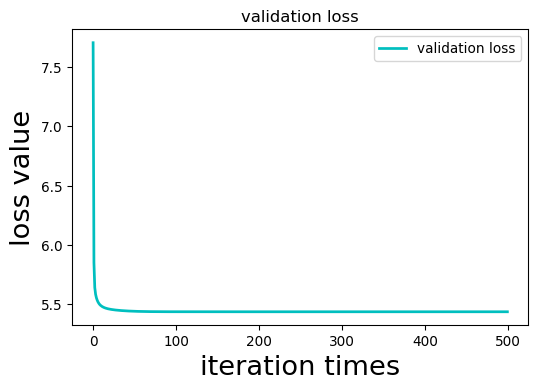

stochastic gradient descent method...
iteration times: 0
iteration times: 100
iteration times: 200
iteration times: 300
iteration times: 400


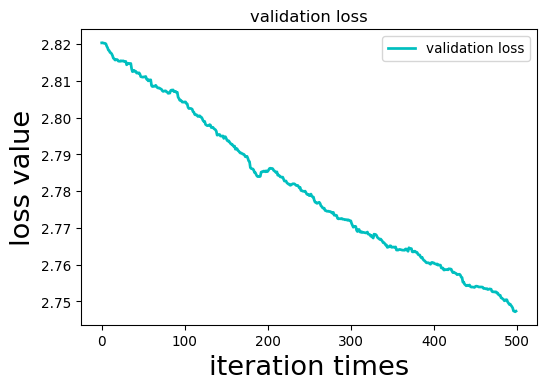

In [22]:
# 文件目录
dir_name = "D:/Coding/python/machinelearning_class_four/data/ml-100k"
task_one(dir_name)
task_two(dir_name)